In [119]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib.mlab as mlab
from microphone import record_audio

In [120]:
from microphone import record_audio
listen_time = 8  # seconds
frames, sample_rate = record_audio(listen_time)

audio_data = np.hstack([np.frombuffer(i, np.int16) for i in frames])

Using input device 'Built-in Microphone'
Recording ended


<IPython.core.display.Javascript object>


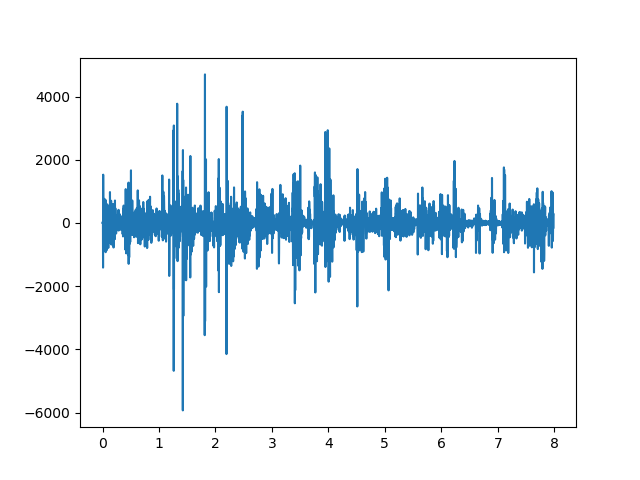

In [121]:
fig, ax = plt.subplots()

time = np.arange(len(audio_data)) / sampling_rate

ax.plot(time[::100], audio_data[::100]) # plot every 100th point in the waveform

<IPython.core.display.Javascript object>


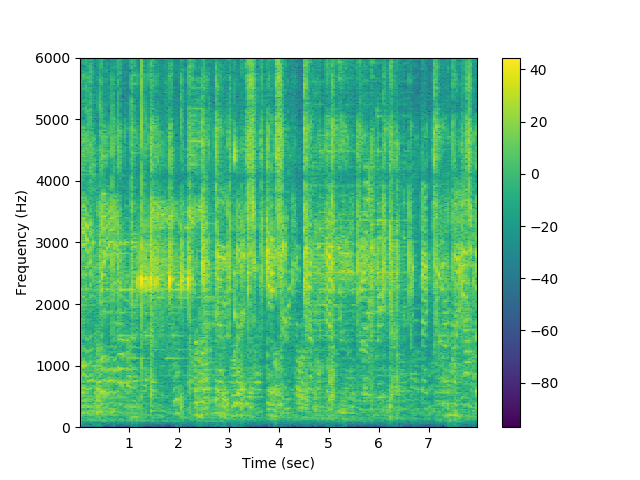

In [122]:
fig, ax = plt.subplots()

S, freqs, times, im = ax.specgram(audio_data, NFFT=4096, Fs=sampling_rate,
                                  window=mlab.window_hanning,
                                  noverlap=4096 // 2)
fig.colorbar(im)

ax.set_xlabel("Time (sec)")
ax.set_ylabel("Frequency (Hz)")
ax.set_ylim(0, 6000);

In [135]:
def spectrogram_to_cutoff(spectrogram, frac_cut = 0.9):
    """ Given the values of a spectrogram, return the cutoff value that 
        distinguishes the foreground from the background.
        
        Parameters
        ----------
        spectrogram : numpy.ndarray, shape = (N, M)
            2D array of shape (N, M)
            
        frac_cut : int
            the percentage of lower amplitudes that wull be considered 
            background
            
        Returns
        -------
        The cutoff value used to distinguish the foreground from the 
        background. """
        
    spectrogram[spectrogram <= 0] = 1e-15
    
    flat_spec = np.log(spectrogram.flatten())
    N = len(flat_spec)
    
    hist, bin_edges = np.histogram(flat_spec, bins = int(N / 2), density = True)
    bin_size = np.diff(bin_edges)
    
    cumulative_distr = np.cumsum(hist * bin_size)
    
    bin_index_of_cutoff = np.searchsorted(cumulative_distr, frac_cut)
    
    # given the bin-index, we want the associated log-amplitude value for that bin
    cutoff = bin_edges[bin_index_of_cutoff]
    return cutoff

In [134]:
audio_cutoff = spectrogram_to_cutoff(S)
print(audio_cutoff)

(2049, 171)
(350379,)
1.68180309388


In [129]:
def spectrogram_to_peaks(spectrogram, cutoff):
    """ Given a spectrogram, return its peaks, which are all local peaks
        with values greater than the cutoff. 
        
        Parameters
        ----------
        spectrogram : numpy.ndarray, shape = (N, M)
            2D array of shape (N, M)
            
        cutoff : float
            elements less than or equal to the cutoff are considered 
            background elements
            
        Returns
        -------
        A bool array of the peaks of a spectrogram. """
    
    # Ryan's neighborhood
    fp = generate_binary_structure(rank = 2, connectivity = 1)
    spec_max = maximum_filter(spectrogram, footprint = iterate_structure(fp, 20))
    return (spectrogram == spec_max) & (spectrogram > cutoff)

In [130]:
peaks = spectrogram_to_peaks(S, audio_cutoff)

In [131]:
T = len(audio_data) / 44100

N = len(audio_data)
max_k = (N // 2) + 1
F = max_k / T

<IPython.core.display.Javascript object>


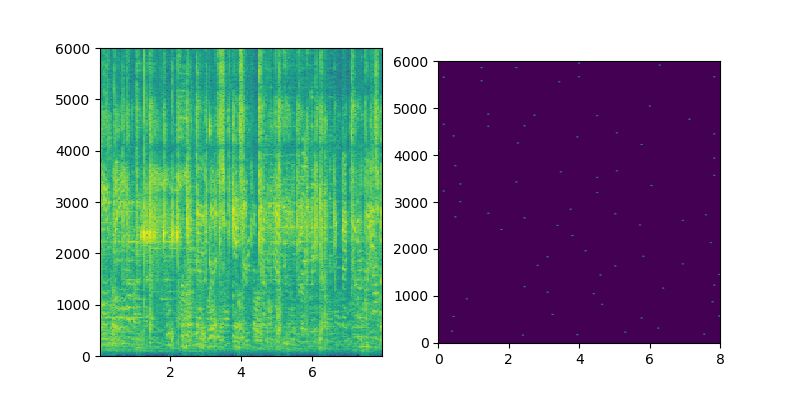

(0, 6000)

In [132]:
max_freq = 6000 # the largest frequency that we want to plot
extent = (0, T, 0, F)  # this is used to set the (left, right, bottom, top) scale for the image axes
aspect_ratio = T/max_freq


fig, axes = plt.subplots(ncols = 2, figsize=(8,4))

S, freqs, times, im = axes[0].specgram(audio_data, NFFT=4096, Fs=sampling_rate,
                                       window=mlab.window_hanning,
                                       noverlap=4096 // 2)

axes[0].set_ylim(0, 6000);

axes[1].imshow(peaks, origin="lower", aspect=aspect_ratio, extent=extent, interpolation="bilinear")
axes[1].set_ylim(0, max_freq)